In [166]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap= 'gray')

In [168]:
coins = cv2.imread('coins.jpg')

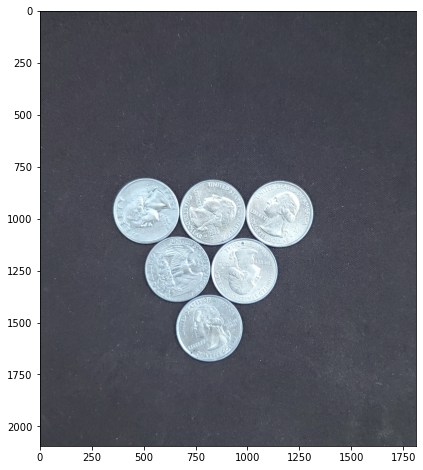

In [169]:
display(coins)

In [170]:
# median blur to avoid detecting unnecessary features
coins_blur = cv2.medianBlur(coins,13)

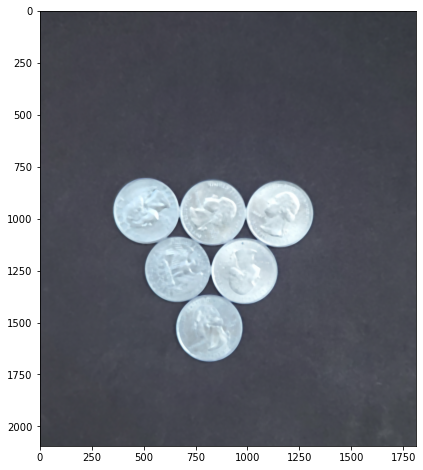

In [171]:
display(coins_blur)

In [172]:
coins_gray = cv2.cvtColor(coins_blur, cv2.COLOR_BGR2GRAY)

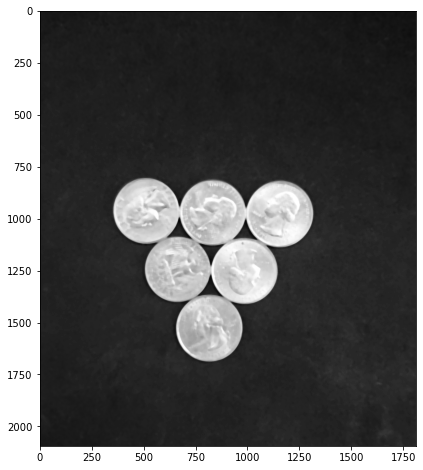

In [173]:
display(coins_gray)

In [174]:
ret, sep_thresh = cv2.threshold(coins_gray,130,255,cv2.THRESH_BINARY)

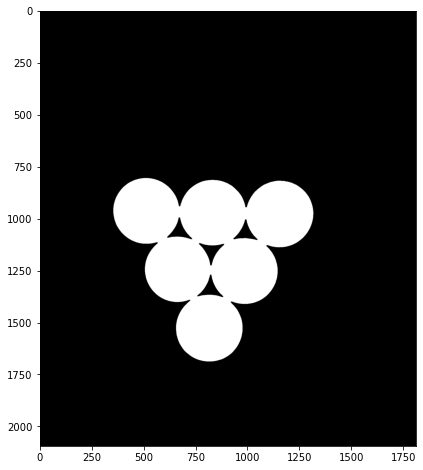

In [175]:
display(sep_thresh)

In [176]:
sep_thresh.shape

(2094, 1810)

In [177]:
contours,hirearchy = cv2.findContours(sep_thresh.copy(), cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

In [178]:
#ideally we are looking for 6 external contours; one for each coin 

for i in range(len(contours)):
    
    if hirearchy[0][i][3] == -1:
        cv2.drawContours(coins,contours,i,(255,0,0),10)

In [179]:
len(contours)

5

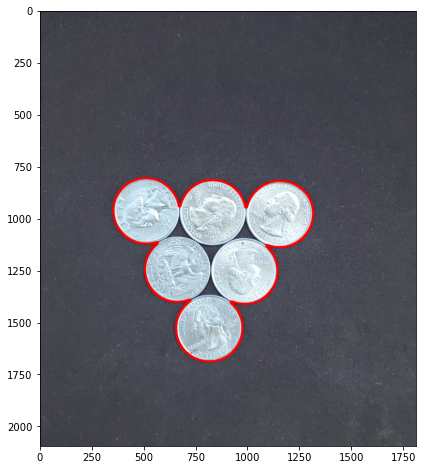

In [180]:
display(coins)

In [181]:
# Let's apply the watershed algorithm now

coins = cv2.imread('coins.jpg')
coins_blur = cv2.medianBlur(coins_gray,13)
coins_gray = cv2.cvtColor(coins,cv2.COLOR_BGR2GRAY)

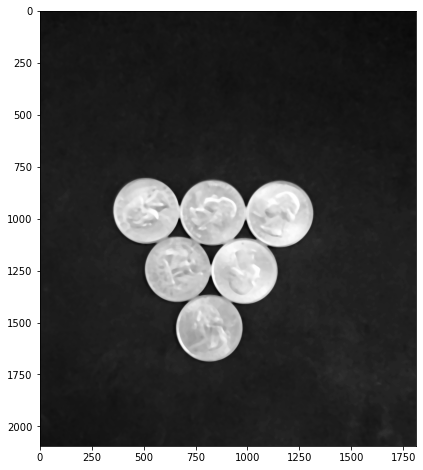

In [182]:
display(coins_blur)

In [183]:
# to use watershed algorithm, it's best to use otsu's thresholding
ret, thresh = cv2.threshold(coins_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

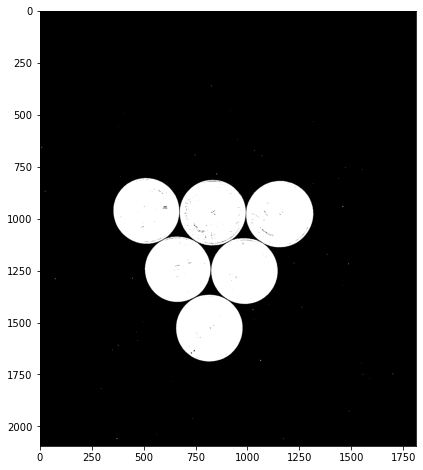

In [184]:
display(thresh)

In [185]:
# noise removal to remove features inside the coin
kernel = np.ones((3,3),np.uint8)

In [186]:
# use closing to get ris on noise in the foreground
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations = 2)

# use closing to get ris on noise in the background
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations = 2)

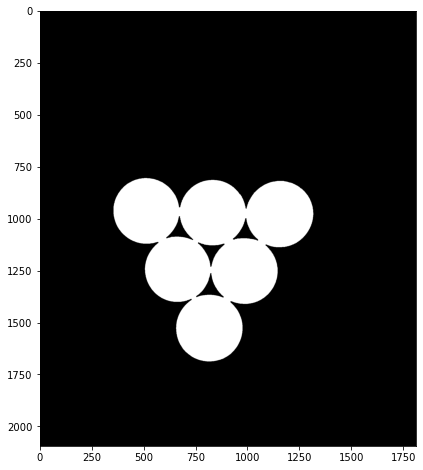

In [187]:
display(opening)

In [188]:
sure_background = cv2.dilate(opening,kernel,iterations=3)

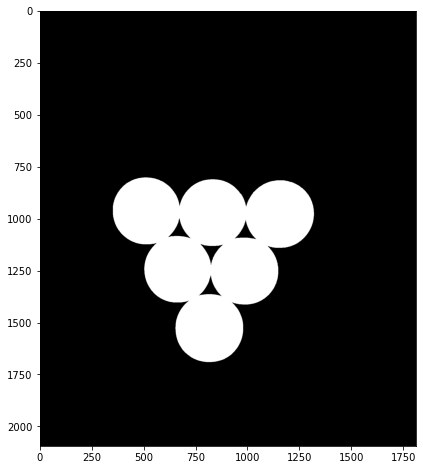

In [189]:
display(sure_background)

In [190]:
dist_trans = cv2.distanceTransform(opening, cv2.DIST_L2,5)

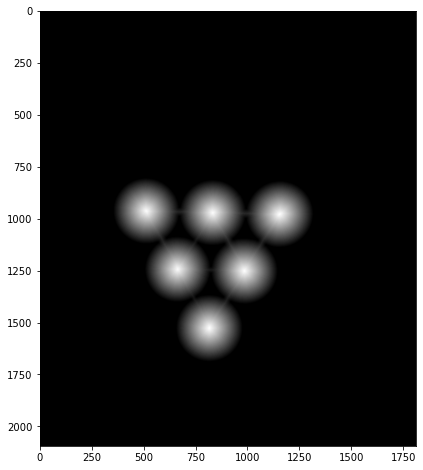

In [191]:
# this is used to create topological mapping; notice how the center is brighter than the edges
display(dist_trans)

In [192]:
ret, sure_foreground = cv2.threshold(dist_trans, 0.8*dist_trans.max(),255,0)

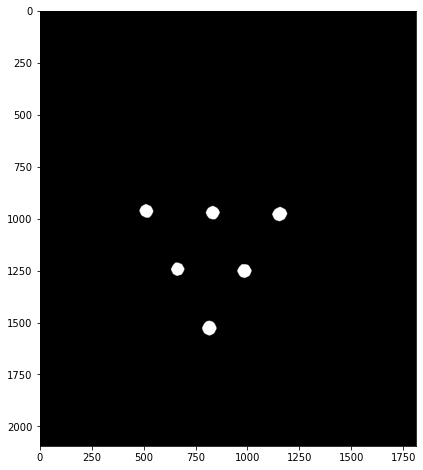

In [193]:
display(sure_foreground)

In [194]:
#they must be of the same type
sure_foreground = np.uint8(sure_foreground)
sure_background = np.uint8(sure_background)

In [195]:
unknown_region = cv2.subtract(sure_background,sure_foreground)

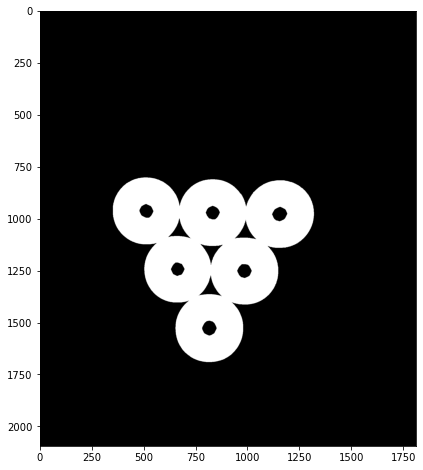

In [196]:
display(unknown_region, cmap = 'gray')

In [197]:
# the sure_foregrounds points will be used to create seeds 

ret,markers = cv2.connectedComponents(sure_foreground)

In [198]:
markers

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

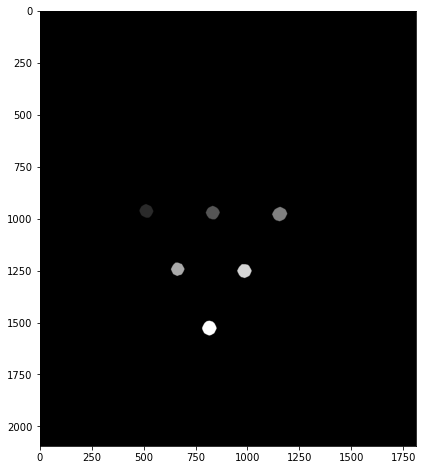

In [199]:
display(markers)

In [200]:
markers = markers + 1

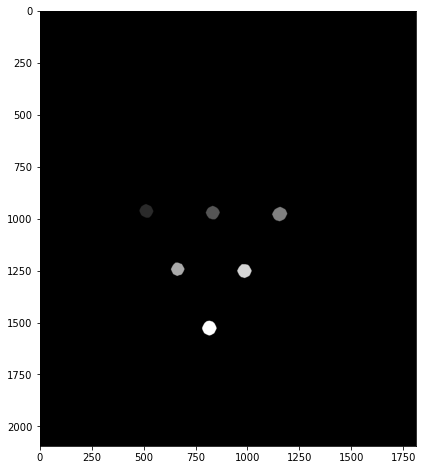

In [201]:
display(markers)

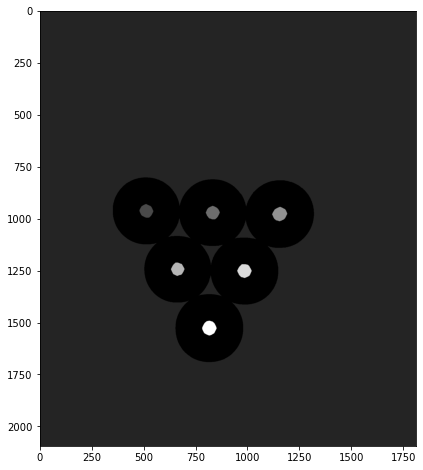

In [202]:
markers[unknown_region == 255] = 0   #make unknown region black
display(markers)

In [203]:
# Apply watershed algorithm to the markers
markers = cv2.watershed(coins,markers)

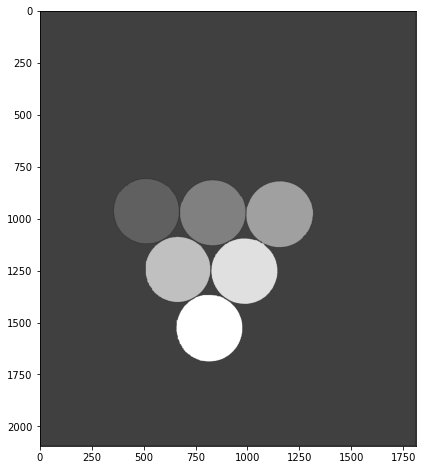

In [204]:
#notice how it was able to find 6 distince markers
display(markers)

In [205]:
# find contours on the markers now
contours,hirearchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

In [206]:
for i in range(len(contours)):
    
    if hirearchy[0][i][3] == -1:
        cv2.drawContours(coins,contours,i,(255,0,0),10)

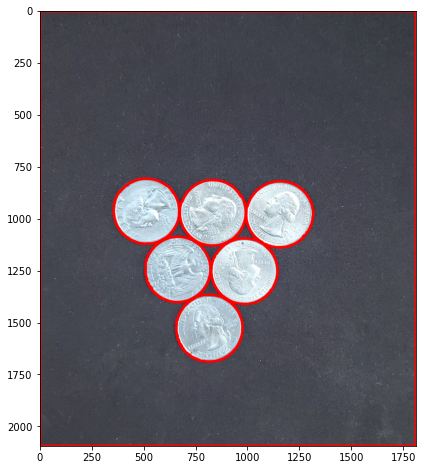

In [207]:
display(coins)

In [208]:
# notice how there are 6 distinct contours for 6 distinct coins
cv2.imwrite('coins_with_contours.jpg',coins)

True